<a href="https://colab.research.google.com/github/rsmarinho/filtros/blob/main/pyscripts/funcoes_aproximacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.polynomial import polynomial as P

In [2]:
#@title plot

# import for plot
from matplotlib import cm
np.seterr(divide='ignore', invalid='ignore') # ignore errors

db = lambda x : 10*np.log10(x) # define decibel

def plot_roots(p, marker='o', img=111):
  # fig, ax = plt.figure()
  
  lim = max(abs(p.r)) + 0.5

  ax = fig.add_subplot(img)

  # Move left y-axis and bottim x-axis to centre, passing through (0,0)
  ax.spines['left'].set_position('center')
  ax.spines['bottom'].set_position('center')

  # Eliminate upper and right axes
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')

  # Show ticks in the left and lower axes only
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')

  ax.scatter(p.r.real, p.r.imag, marker=marker)
  ax.set_aspect('equal', 'box')
  ax.set_xlim(-lim, lim)
  ax.set_ylim(-lim, lim)

def plot_conf(ax, xlim=[1e-1, 1e1], ylim=[-2, 0.3e2]):

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  ax.grid(b=True, which='major', color='lightgray', ls='-')
  ax.grid(b=True, which='minor', color='lightgray', ls='--')

## Butterworth
---

In [3]:
N = 100
W = np.logspace(-1, 1, N)

# determinação do gabarito do filtro
AMAX = 3 #3.0103
AMIN = 40

fp = 400000
fs = 800000

Wp = 2*np.pi*fp
Ws = 2*np.pi*fs
# Wp = 2
# Ws = 3

# calculo da atenuação máxima a partir do gabarito
e = lambda AMAX : np.sqrt(10**(AMAX/10) - 1)

print(f"AMAX : {AMAX}")
print(f"AMIN : {AMIN}")
print(f"fp : {fp}")
print(f"fs : {fs}")
print(f"Wp : {Wp}")
print(f"Ws : {Ws}")

AMAX : 3
AMIN : 40
fp : 400000
fs : 800000
Wp : 2513274.1228718343
Ws : 5026548.245743669


In [4]:
K = lambda n, Wp=Wp, e=e(AMAX), W=W : e * (W/Wp)**n

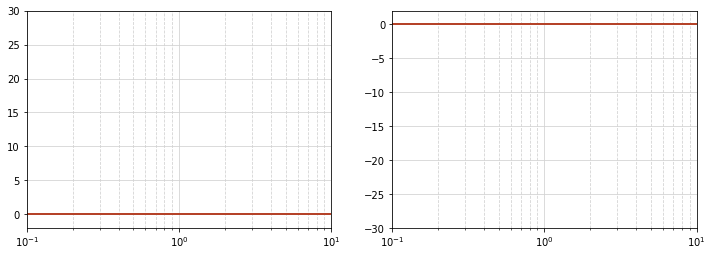

In [5]:
fig = plt.figure(figsize=(12,4))

args = [Wp, e(AMAX), W]

# attenuation
A = lambda n, Wp, e, W : 10*np.log10( 1 + K(n, Wp=Wp, e=e, W=W)**2 )
ax1 = plt.subplot(121)
for i in range(1, 5):
  plt.semilogx(W, A(i, *args))

plot_conf(ax1, xlim=[1e-1, 1e1], ylim=[-2, 0.3e2])

# gain
G = lambda n, Wp, e, W : -A(n, Wp=Wp, e=e, W=W)
ax2 = plt.subplot(122)
for i in range(1, 5):
  plt.semilogx(W, G(i, *args))

plot_conf(ax2, xlim=[1e-1, 1e1], ylim=[-0.3e2, 2])

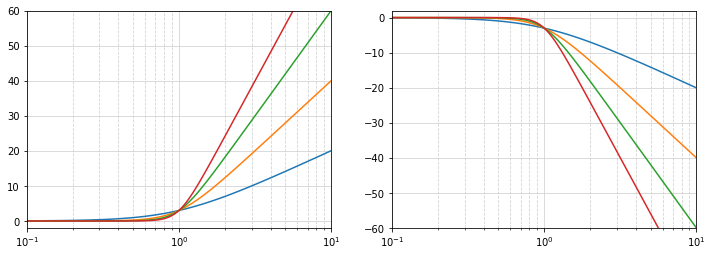

In [6]:
fig = plt.figure(figsize=(12,4))

W_ = np.logspace(-1, 1, N)
args = []

# attenuation
A = lambda n : 10*np.log10( 1 + K(n, W = (Wp * W_ / (e(AMAX)**(1/n)) ) )**2 )
ax1 = plt.subplot(121)
for i in range(1, 5):
  plt.semilogx(W, A(i, *args))

plot_conf(ax1, xlim=[1e-1, 1e1], ylim=[-2, 0.6e2])

# gain
G = lambda n : -A(n)
ax2 = plt.subplot(122)
for i in range(1, 5):
  plt.semilogx(W, G(i, *args))

plot_conf(ax2, xlim=[1e-1, 1e1], ylim=[-0.6e2, 2])

Determinação da ordem do filtro:
$$
n \geq \dfrac{\log[(10^{\frac{A_{MIN}}{10}}-1)/(10^{\frac{A_{MAX}}{10}}-1)]}{2\log(\omega_s/\omega_p)}
$$

In [7]:
n = np.log10( (10**(AMIN/10)-1) / (10**(AMAX/10)-1) ) / (2 * np.log10(Ws/Wp))
n = int(np.ceil(n))
# n=3
print(f"ordem >= {n}")

ordem >= 7


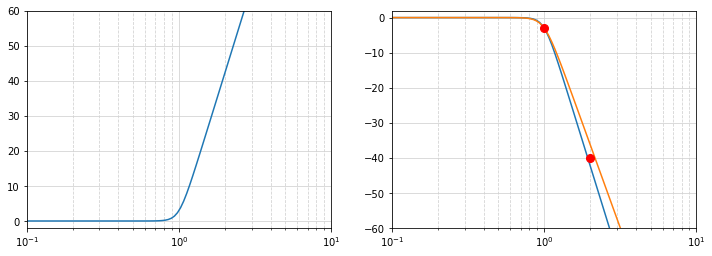

In [8]:
fig = plt.figure(figsize=(12,4))

# attenuation
A = lambda n :  1 + K(n, W = (Wp * W_ / (e(AMAX)**(1/n)) ) )**2 
ax1 = plt.subplot(121)

plt.semilogx(W_, db(A(n)))
plot_conf(ax1, xlim=[1e-1, 1e1], ylim=[-2, 0.6e2])

# gain
ax2 = plt.subplot(122)

plt.semilogx(W_, db(1/A(n)) )
plt.semilogx(W_, db(1/A(n-1)) )
plt.semilogx(Wp/Wp, -AMAX, 'ro', ms=8)
plt.semilogx(Ws/Wp, -AMIN, 'ro', ms=8)

plot_conf(ax2, xlim=[1e-1, 1e1], ylim=[-0.6e2, 2])

In [9]:
def K(n):
  p = np.zeros(n + 1)
  p[0] = 1
  return np.poly1d(p)

def H(n, e=e(AMAX)):
  return np.poly1d( np.polyadd( e**2 * K(n)**2, [1] ) )

In [10]:
# essa função tem os zeros ao longo do circulo unitário
# do plano-s igualmente espaçados à partir do eixo real
# negativo
H_bw = H(n)
print(H_bw)

        14
0.9953 x  + 1


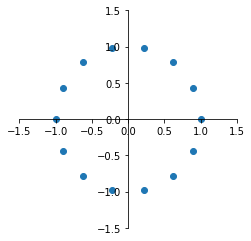

In [11]:
# substituindo s=jW

x = np.poly1d([1j, 0]) 
H2 = np.poly1d( np.polyval( H_bw, x ) )

fig = plt.figure()
plot_roots(H2)

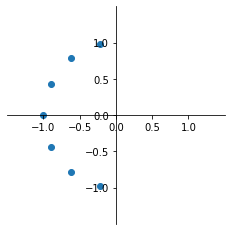

In [12]:
# utilizar apenas raizes negativas (estabilidade)
rn = np.where(H2.roots.real < 0)
bw_filter = np.poly1d(P.polyfromroots(H2.r[rn]))

fig = plt.figure()
plot_roots(bw_filter)

In [13]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

x = np.poly1d([1j, 0]) 
p = []
for i in range(1,9):
  p = H(i)
  p = np.poly1d(np.polyval(p, x))
  rn = np.where(p.roots.real < 0)
  bw_table = np.poly1d(P.polyfromroots(p.r[rn]))
  print(f"{i} : {bw_table.coef.real}")

1 : [1.0024 1.0000]
2 : [1.0024 1.4159 1.0000]
3 : [1.0024 2.0032 2.0016 1.0000]
4 : [1.0024 2.6178 3.4183 2.6147 1.0000]
5 : [1.0024 3.2422 5.2435 5.2410 3.2376 1.0000]
6 : [1.0024 3.8714 7.4759 9.1525 7.4700 3.8652 1.0000]
7 : [1.0024 4.5031 10.1150 14.6116 14.6067 10.1047 4.4955 1.0000]
8 : [1.0024 5.1365 13.1605 21.8786 25.7189 21.8656 13.1449 5.1274 1.0000]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


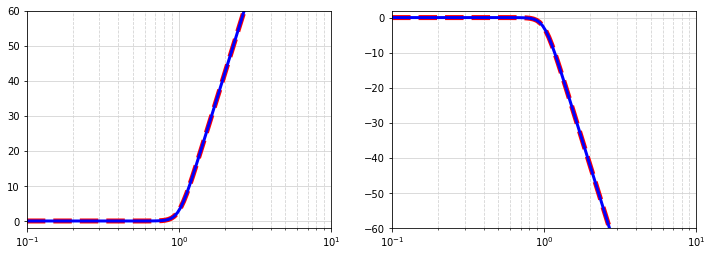

In [14]:
fig = plt.figure(figsize=(12,4))

A = lambda w : H2(w)
AA = lambda w : bw_filter(w)**2

# attenuation
ax1 = plt.subplot(121)

plt.semilogx(W, db(A(1j*W)), '--r', lw=5)
plt.semilogx(W, db(AA(1j*W)), 'b', lw=3)

plot_conf(ax1, xlim=[1e-1, 1e1], ylim=[-2, 0.6e2])

# gain
ax2 = plt.subplot(122)

plt.semilogx(W, -db(A(1j*W)), '--r', lw=5)
plt.semilogx(W, -db(AA(1j*W)), 'b', lw=3)

plot_conf(ax2, xlim=[1e-1, 1e1], ylim=[-0.6e2, 2])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


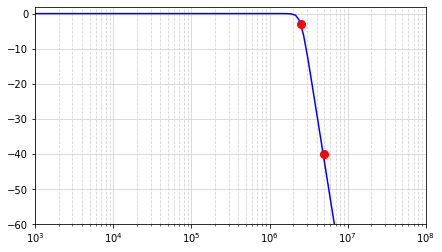

In [15]:
W = np.logspace(3, 8, N)

fig = plt.figure(figsize=(7,4))

# gain
ax = plt.subplot(111)

plt.semilogx(W, db(1/AA(1j*W/Wp)), 'b')

plt.semilogx(Wp, -AMAX, 'ro', ms=8)
plt.semilogx(Ws, -AMIN, 'ro', ms=8)

plot_conf(ax, xlim=[1e3, 1e8], ylim=[-0.6e2, 2])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


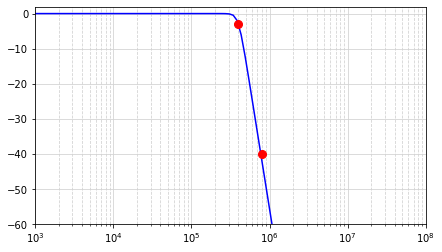

In [16]:
F = W/(2*np.pi)

fig = plt.figure(figsize=(7,4))

# gain
ax = plt.subplot(111)

plt.semilogx(F, db(1/AA(1j*W/Wp)), 'b')

plt.semilogx(fp, -AMAX, 'ro', ms=8)
plt.semilogx(fs, -AMIN, 'ro', ms=8)

plot_conf(ax, xlim=[1e3, 1e8], ylim=[-0.6e2, 2])

## Chebyshev
---

In [17]:
# %reset -f
N = 100
W = np.logspace(-1, 1, N)

# determinação do gabarito do filtro
AMAX = 3 #3.0103
AMIN = 40

fp = 400000
fs = 800000

Wp = 2*np.pi*fp
Ws = 2*np.pi*fs
# Wp = 2
# Ws = 3

# calculo da atenuação máxima a partir do gabarito
e = lambda AMAX : np.sqrt(10**(AMAX/10) - 1)

print(f"AMAX : {AMAX}")
print(f"AMIN : {AMIN}")
print(f"fp : {fp}")
print(f"fs : {fs}")
print(f"Wp : {Wp}")
print(f"Ws : {Ws}")

AMAX : 3
AMIN : 40
fp : 400000
fs : 800000
Wp : 2513274.1228718343
Ws : 5026548.245743669


In [18]:
def TT(n,w): # First Order Chebyshev Polynomial
  ans = np.zeros(w.shape)
  for i, v in enumerate(w):
    if abs(v) < 1:
      ans[i] = np.cos(n*np.arccos(v))
    if v >= 1:
      ans[i] = np.cosh(n*np.arccosh(v))
    if v <= -1:
      ans[i] = ((-1)**n)*np.cosh(n*np.arccosh(-v))
  return ans

def UU(n,c): # Second Order Chebyshev Polynomial
  return np.sin((n+1)*np.arccos(c))/np.sin(np.arccos(c))

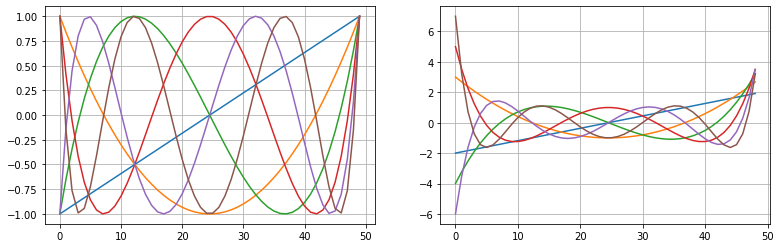

In [19]:
X = np.linspace(-1,1)
fig = plt.figure(figsize=(13,4))

plt.subplot(121)
plt.grid(True)
for i in range(1,7):
  plt.plot(TT(i, X))

plt.subplot(122)
plt.grid(True)
for i in range(1,7):
  plt.plot(UU(i, X))

In [20]:
def Cn(n, W): # função geradora polinomio Chebyshev I (Função Tn)
  ans = np.zeros(W.shape)
  ans[np.where(W<=1)] = np.cos(n*np.arccos(W[np.where(W<=1)]))
  ans[np.where(W>1)] = np.cosh(n*np.arccosh(W[np.where(W>1)]))

  return ans

def K(n, W):
  return Cn(n, W)

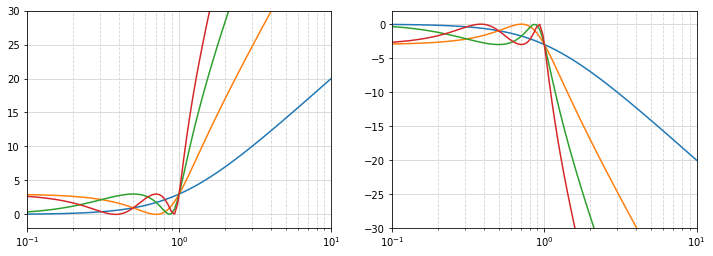

In [21]:
fig = plt.figure(figsize=(12,4))

args = [W, e(AMAX)]

# attenuation
A = lambda n, W, e=e(AMAX) : 1 + e**2 * K(n, W=W)**2
ax1 = plt.subplot(121)
for i in range(1, 5):
  plt.semilogx(W, db(A(i, *args)) )

plot_conf(ax1, xlim=[1e-1, 1e1], ylim=[-2, 0.3e2])

# gain
ax2 = plt.subplot(122)
for i in range(1, 5):
  plt.semilogx(W, db(1/A(i, *args)) )

plot_conf(ax2, xlim=[1e-1, 1e1], ylim=[-0.3e2, 2])

Determinação da ordem do filtro:
$$
n \geq \dfrac{\mbox{arccosh}[(10^{\frac{A_{MIN}}{10}}-1)/(10^{\frac{A_{MAX}}{10}}-1)]^{\frac{1}{2}}}{\mbox{arccosh}log(\omega_s/\omega_p)}
$$

In [22]:
n = np.sqrt(np.arccosh( (10**(AMIN/10)-1) / (10**(AMAX/10)-1) )) / (np.arccosh(Ws/Wp))
n = np.ceil(n)
# n = 4
print(f"ordem >= {n}")

ordem >= 3.0


In [23]:
import sympy as sym

s = sym.symbols('s')
sym.init_printing(use_unicode=True)

In [24]:
# geração do polinômio utilizando a relação de
def T_sym(n):
  if n == 0 :
    return 1
  if n == 1 :
    return s
  else :
    return sym.Poly(2*(s)*T_sym(n-1) - T_sym(n-2))

def T(n):
  return np.poly1d(sym.Poly(T_sym(n)).all_coeffs())

def Cn_(n): 
  return T(n)

# def Cn_(n): 
#   rn = np.where(T(n).r<0)
#   Hn = np.poly1d(P.polyfromroots(T(n).r[rn]))
#   return Hn

def K_( n, e=e(AMAX) ):
  ripple = float(e)
  return ripple*Cn_(n)

def H_(n, e=e(AMAX)): 
  return np.poly1d( np.polyadd( K_(n, e)**2, [1] ) )

In [25]:
# from sympy.utilities.lambdify import lambdify

# X = np.linspace(-1,1)
# fig = plt.figure(figsize=(13,4))

# def TT_(n):
#   return lambdify(s, T_sym(n), 'numpy')

# for i in range(1,7):
#   plt.plot(X, TT_(i)(X))
# plt.grid(True)

In [26]:
H_cheb1 = H_(n)
print(H_cheb1)

       6         4         2
15.92 x - 23.89 x + 8.957 x + 1


        6         4         2
-15.92 x - 23.89 x - 8.957 x + 1


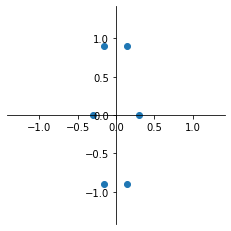

In [27]:
x = np.poly1d([1j, 0]) # s=j\omega
cheby1_filter = np.poly1d(np.polyval(H_cheb1, x))
print(cheby1_filter)

fig = plt.figure()
plot_roots(cheby1_filter)

3.0


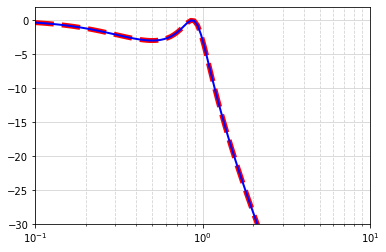

In [28]:
print(n)
A = lambda n, W, e=e(AMAX) : 1 + e**2 * K(n, W=W)**2

args = [W, e(AMAX)]
ax1 = plt.subplot(111)

plt.semilogx(W, -db(A(n, *args)), '--r', lw=5)
plt.semilogx(W, -db(np.array(cheby1_filter(1j*W), dtype=np.float)), 'b', lw=2)

plot_conf(ax1, xlim=[1e-1, 1e1], ylim=[-0.3e2, 2])

In [29]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.0f}".format(x)})
p = []
x = np.poly1d([1j, 0]) # s=j\omega
for i in range(1,9):
  cheby1_table = np.poly1d(np.polyval(H_(i), x))
  print(f"{i} : {np.array(cheby1_table.coef, dtype=float)}")

1 : [-1 0 1]
2 : [4 0 4 0 2]
3 : [-16 0 -24 0 -9 0 1]
4 : [64 0 127 0 80 0 16 0 2]
5 : [-255 0 -637 0 -557 0 -199 0 -25 0 1]
6 : [1019 0 3057 0 3440 0 1784 0 418 0 36 0 2]
7 : [-4077 0 -14268 0 -19619 0 -13376 0 -4682 0 -780 0 -49 0 1]
8 : [16306 0 65226 0 105991 0 89685 0 42040 0 10701 0 1338 0 64 0 2]


## Chebyshev Inverso
---

In [30]:
# %reset -f
N = 100
W = np.logspace(-1, 1, N)

# determinação do gabarito do filtro
AMAX = 3 #3.0103
AMIN = 20

fp = 400000
fs = 800000

# Wp = 2*np.pi*fp
# Ws = 2*np.pi*fs
Wp = 2
Ws = 3

# calculo da atenuação máxima a partir do gabarito
e = lambda AMAX : np.sqrt(10**(AMAX/10) - 1)

print(f"AMAX : {AMAX}")
print(f"AMIN : {AMIN}")
print(f"fp : {fp}")
print(f"fs : {fs}")
print(f"Wp : {Wp}")
print(f"Ws : {Ws}")

AMAX : 3
AMIN : 20
fp : 400000
fs : 800000
Wp : 2
Ws : 3


Para o filtro Chebyshev invertido, temos que

$$
K(\omega) = \dfrac{1}{\sigma^2C_n^2(\omega_s/\omega)}
$$

Também definimos anteriormente que a função de atenuação $A(\omega)$, é dada por

$$
A(\omega)=10\log[1+\varepsilon^2K^2(\omega)]
$$
$$
A(\omega)=10\log[1+\varepsilon^2\left[\dfrac{1}{\sigma^2C_n^2(\omega_s/\omega)}\right]^2(\omega)]
$$

se reescrevermos $A(\omega)$ como

$$
A(\omega)=10\log\left[1+\dfrac{1}{\sigma^2C_n^2(\omega_s)}\cdot\dfrac{C_n^2(\omega_s)}{C_n^2(\omega_s/\omega)}\right]
$$

temos que
$$
\varepsilon^{'2} = \dfrac{1}{\sigma^2C_n^2(\omega_s)}
$$

e
$$
K^{'2} = \dfrac{C_n^2(\omega_s)}{C_n^2(\omega_s/\omega)}
$$

portanto
$$
A(\omega)=10\log[1+\varepsilon^{'2}K^{'2}(\omega)]
$$



In [31]:
def Cn(n, W):
  ans = np.zeros(len(W))
  ans[np.where(W<=1)] = np.cos(n*np.arccos(W[np.where(W<=1)]))
  ans[np.where(W>1)] = np.cosh(n*np.arccosh(W[np.where(W>1)]))

  return ans

def K(n, W, sigma):
  return 1 / ( sigma * Cn(n, 1/W) ) 

def K_(n, W, Ws):
  return Cn(n, np.array([Ws])) / ( Cn(n, Ws/W) ) 

0.10062317407880222


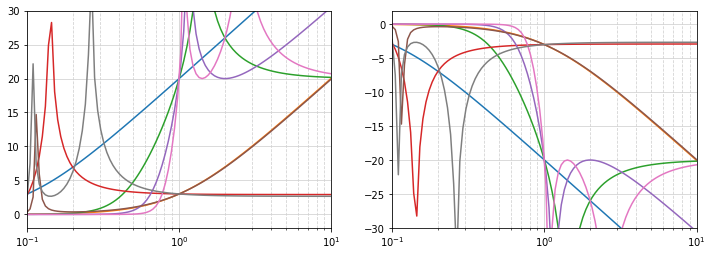

In [32]:
# AMAX = 0.001

fig = plt.figure(figsize=(12,4))

sig = lambda n, Ws, e=e(AMAX) : np.sqrt(1/(e*Cn(n, np.array([Ws]))))
ss = sig(n, Ws, e(AMAX))
print(*ss)
args = [W, *ss]
# args = [W, 1]

# attenuation
A = lambda n, W, sigma : 1 + K(n, W=W, sigma=sigma)**2
Aa = lambda n, W, Ws : 1 + K_(n, W=W, Ws=Ws)**2
ax1 = plt.subplot(121)
for i in range(1, 5):
  plt.semilogx(W, db(A(i, *args)) )
  plt.semilogx(W, db(Aa(i, *args)) )

plot_conf(ax1, xlim=[1e-1, 1e1], ylim=[-2, 0.3e2])

# gain
ax2 = plt.subplot(122)
for i in range(1, 5):
  plt.semilogx(W, -db(A(i, *args)) )
  plt.semilogx(W, -db(Aa(i, *args)) )

plot_conf(ax2, xlim=[1e-1, 1e1], ylim=[-0.3e2, 2])

Determinação da ordem do filtro:
$$
n \geq \dfrac{\mbox{arccosh}[(10^{\frac{A_{MIN}}{10}}-1)/(10^{\frac{A_{MAX}}{10}}-1)]^{\frac{1}{2}}}{\mbox{arccosh}log(\omega_s/\omega_p)}
$$

## Bessel
---

## Cauer
---